In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.set_random_seed(0)

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

In [2]:
mnist = read_data_sets('data', one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_true = tf.placeholder(tf.float32, [None, 10])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [4]:
X1 = tf.reshape(X, [-1, 784])

In [5]:
# The model
Y_pred = tf.nn.softmax(tf.matmul(X1, W) + b)

# loss function
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred))

In [6]:
is_correct = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y_true, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [7]:
learning_rate = 0.003
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [9]:
from ipywidgets import *
import bqplot.pyplot as plt

n = 2000
acc_fig = plt.figure(title='Accuracy', legend_location='bottom-right')
x = np.arange(1, n+1)
axes_options = {'x': {'label': 'Iterations', 'num_ticks': 5},
                'y': {'tick_format': '.0%'}}
acc_plot = plt.plot(x, [], display_legend=True, 
                    labels=['Train', 'Test'], colors=['green', 'blue'],
                    axes_options=axes_options)

loss_fig = plt.figure(title='Loss')
loss_plot = plt.plot(np.arange(1, n+1), [], display_legend=True, 
                     labels=['Train', 'Test'], 
                     colors=['green', 'blue'],
                     axes_options={'x': {'label': 'Iterations', 
                                         'num_ticks': 5},
                                   'y': {'tick_format': ','}})
HBox([acc_fig, loss_fig])

A Jupyter Widget

In [10]:
from time import sleep

train_a = []
test_a = []
train_loss = []
test_loss = []

for i in range(2000):
    # load batch of images and correct answers
    batch_X, batch_Y = mnist.train.next_batch(100) 
    train_data = {X: batch_X, Y_true: batch_Y}

    # train
    sess.run(train_step, feed_dict=train_data)
    a, c = sess.run([accuracy, cross_entropy], feed_dict=train_data)
    train_a.append(a)
    train_loss.append(c * 100)
    
    # run on test data
    test_data = {X: mnist.test.images, Y_true: mnist.test.labels}
    a, c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
    test_a.append(a)
    test_loss.append(c)
    
    sleep(.001)
    if i % 20 == 0:
        acc_plot.y = [train_a, test_a]
        loss_plot.y = [train_loss, test_loss]

In [11]:
from sklearn.metrics import confusion_matrix

In [14]:
# true test labels
y_true = np.argmax(mnist.test.labels, 1)
test_data = {X: mnist.test.images, Y_true: mnist.test.labels}

# pred test labels
y_pred = np.argmax(sess.run(Y_pred, feed_dict=test_data), 1)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

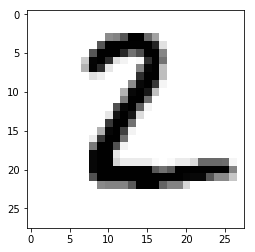

In [16]:
plt.imshow(np.squeeze(mnist.test.images[1]), cmap=plt.cm.binary)

In [17]:
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat

array([[ 956,    0,    0,    2,    0,    6,   10,    3,    2,    1],
       [   0, 1114,    4,    1,    0,    2,    4,    2,    8,    0],
       [   3,    6,  941,   17,   14,    3,   14,   10,   20,    4],
       [   3,    0,   26,  909,    0,   25,    4,   11,   21,   11],
       [   1,    1,    2,    1,  913,    0,   13,    3,    9,   39],
       [   8,    3,    3,   26,    9,  789,   16,    6,   25,    7],
       [   8,    3,    5,    1,    8,   13,  917,    2,    1,    0],
       [   1,    5,   23,    7,    5,    0,    0,  949,    2,   36],
       [   5,   10,    9,   22,    9,   28,   13,   14,  854,   10],
       [   9,    7,    1,    9,   27,    7,    0,   26,    4,  919]])

In [18]:
from bqplot import *

class ConfusionMatrix(Figure):
    def __init__(self, *args, **kwargs):
        self.conf_mat = kwargs['confusion_matrix']
        self.labels = kwargs['labels']
        row_scale = OrdinalScale(reverse=True)
        col_scale = OrdinalScale()
        color_scale = ColorScale(scheme='Greens')
        row_axis = Axis(scale=row_scale, orientation='vertical', label='Actual')
        col_axis = Axis(scale=col_scale, label='Predicted', side='top')
        self.conf_mat_grid = GridHeatMap(
            column=self.labels,
            row=self.labels,
            color=(self.conf_mat ** .3),
            scales={'row': row_scale, 'column': col_scale, 'color': color_scale},
            interactions={'click': 'select'},
            anchor_style={'stroke': 'red', 'stroke-width': 3},
            selected_style={'stroke': 'red'})

        n = len(self.labels)
        y, x, text = zip(*[(self.labels[i],
                            self.labels[j],
                            str(self.conf_mat[i, j])) for i in range(n) for j in range(n)])

        self.grid_labels = Label(x=x, y=y, text=text,
                                 scales={'x': col_scale, 
                                         'y': row_scale},
                                 font_size=16,
                                 align='middle',
                                 colors=['black'])

        # self.title = 'Confusion Matrix'
        self.marks = [self.conf_mat_grid, self.grid_labels]
        self.padding_y = 0.0
        self.axes = [row_axis, col_axis]
        self.fig_margin = dict(left=80, top=80, bottom=40, right=40)
        self.layout.width = '460px'
        self.layout.height = '400px'
        
        super(ConfusionMatrix, self).__init__(*args, **kwargs)

In [19]:
cm = ConfusionMatrix(confusion_matrix=conf_mat, labels=np.arange(10))
cm

A Jupyter Widget